Image Deconvolution (ADMM w/ Total Variation)
=============================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
an image deconvolution problem with anisotropic total variation (TV)
regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - A \mathbf{x} \|_2^2
  + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is Toeplitz matrix, $\mathbf{y}$ is the blurred image, $C$
is a 2D Finite Difference operator, and $\mathbf{x}$ is the desired
image.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Set up an ADMM solver object.

In [4]:
λ = 2e-2  # L1 norm regularization parameter
ρ = 5e-1  # ADMM penalty parameter
maxiter = 50  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
# Penalty parameters must be accounted for in the gi functions, not as
# additional inputs.
g = λ * functional.L1Norm()  # regularization functionals gi
C = linop.FiniteDifference(input_shape=x_gt.shape)  # analysis operators Ci
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.adj(y),
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(),
    verbose=True,
)

Run the solver.

In [5]:
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.41e+00  2.824e+02    9.857e+00  7.273e+00
   1  3.32e+00  3.144e+02    2.890e+00  5.532e+00
   2  3.35e+00  3.081e+02    1.970e+00  4.037e+00
   3  3.39e+00  3.060e+02    1.541e+00  3.638e+00
   4  3.42e+00  3.046e+02    1.189e+00  3.337e+00
   5  3.45e+00  3.035e+02    9.830e-01  3.029e+00
   6  3.47e+00  3.025e+02    8.615e-01  2.740e+00


   7  3.50e+00  3.017e+02    7.609e-01  2.487e+00
   8  3.52e+00  3.011e+02    6.749e-01  2.277e+00
   9  3.55e+00  3.005e+02    5.928e-01  2.111e+00
  10  3.57e+00  3.001e+02    5.195e-01  1.971e+00
  11  3.59e+00  2.997e+02    4.669e-01  1.848e+00
  12  3.61e+00  2.993e+02    4.222e-01  1.744e+00
  13  3.62e+00  2.990e+02    3.858e-01  1.653e+00
  14  3.64e+00  2.987e+02    3.501e-01  1.576e+00
  15  3.66e+00  2.984e+02    3.202e-01  1.511e+00
  16  3.69e+00  2.982e+02    2.945e-01  1.451e+00


  17  3.71e+00  2.980e+02    2.779e-01  1.391e+00
  18  3.73e+00  2.978e+02    2.635e-01  1.334e+00
  19  3.75e+00  2.976e+02    2.492e-01  1.282e+00
  20  3.78e+00  2.974e+02    2.334e-01  1.238e+00
  21  3.80e+00  2.972e+02    2.182e-01  1.198e+00
  22  3.82e+00  2.971e+02    2.047e-01  1.162e+00
  23  3.84e+00  2.969e+02    1.920e-01  1.128e+00
  24  3.86e+00  2.968e+02    1.819e-01  1.096e+00
  25  3.88e+00  2.967e+02    1.736e-01  1.064e+00
  26  3.90e+00  2.965e+02    1.671e-01  1.032e+00


  27  3.92e+00  2.964e+02    1.615e-01  1.003e+00
  28  3.94e+00  2.963e+02    1.539e-01  9.764e-01
  29  3.96e+00  2.962e+02    1.475e-01  9.494e-01
  30  3.99e+00  2.961e+02    1.425e-01  9.235e-01
  31  4.02e+00  2.960e+02    1.356e-01  8.994e-01
  32  4.04e+00  2.959e+02    1.291e-01  8.767e-01
  33  4.06e+00  2.959e+02    1.254e-01  8.544e-01
  34  4.08e+00  2.958e+02    1.201e-01  8.345e-01
  35  4.09e+00  2.957e+02    1.163e-01  8.144e-01
  36  4.11e+00  2.956e+02    1.127e-01  7.956e-01


  37  4.13e+00  2.956e+02    1.075e-01  7.787e-01
  38  4.15e+00  2.955e+02    1.041e-01  7.619e-01
  39  4.17e+00  2.954e+02    1.023e-01  7.447e-01
  40  4.18e+00  2.954e+02    9.960e-02  7.288e-01
  41  4.20e+00  2.953e+02    9.633e-02  7.132e-01
  42  4.21e+00  2.953e+02    9.561e-02  6.967e-01
  43  4.22e+00  2.952e+02    9.209e-02  6.814e-01
  44  4.24e+00  2.952e+02    9.063e-02  6.659e-01
  45  4.25e+00  2.951e+02    8.812e-02  6.522e-01
  46  4.27e+00  2.951e+02    8.565e-02  6.384e-01
  47  4.28e+00  2.950e+02    8.389e-02  6.252e-01
  48  4.30e+00  2.950e+02    8.164e-02  6.121e-01
  49  4.31e+00  2.950e+02    7.952e-02  5.996e-01


Show the recovered image.

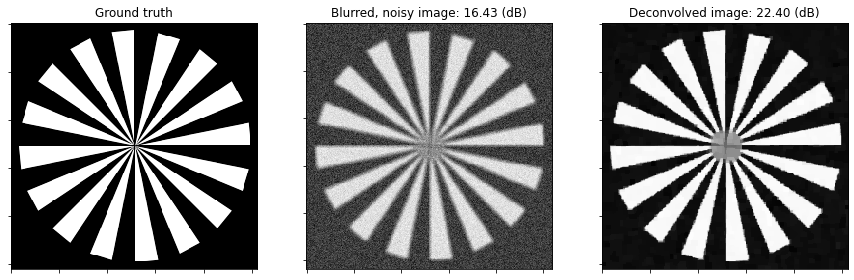

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(
    solver.x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, solver.x), fig=fig, ax=ax[2]
)
fig.show()

Plot convergence statistics.

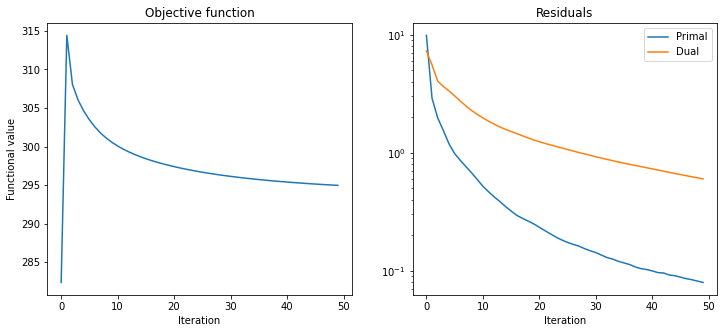

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Primal_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()